# Fellowship.AI Challenge: Food-101

## Notebook Layout <a id='top'></a>
  * [Imports](#imports)
  * [Data](#data)
    * [Preparation](#data-preparation)
      * [Class Distribution and Validation](#data-class-dist-val)
    * [Loading](#data-loading)
      * [Transformations](#data-transformations)
  * [Model](#model)
    * [Architecture and Instantiation](#model-architecture-inst)
  * [Training](#training)
    * [Learning Rate](#training-learning-rate)
    * [Fitting](#training-fitting)
  * Testing
  
Please note that this notebook is structured such that each cell is meant to be run in sequence from top to bottom.

# Imports <a id='imports'></a>
The primary package used in this challenge is [fast.ai's](https://www.fast.ai) fantastic deep learning [library](https://github.com/fastai/fastai). This library is built on top of [PyTorch](https://pytorch.org) and adds a number of convenience functions for data loading, training and testing. Though I will be using much of fast.ai's funcionality in this challenge, I have done my best to thoroughly explain the underlying process and how it sits on top of PyTorch.

Note that despite generally accepting Python practice, fast.ai recommends an import * for ease of use. To be consistent with their conventions I have done that below.

In [93]:
from fastai.vision import *
import pandas as pd

%matplotlib inline

# Data <a id='data'></a>

## Preparation <a id='data-preparation'></a>
In the following cells, I prepare the data and corresponding labels that will be used to create the data bunch. The data bunch holds the training, validation and test sets and is how the images will be handed to the model. The original data set contains a folder of images by image class and a set of text files describing which images belong to the training and test set--the data bunch will be created from this.

In [81]:
path = Path('data/food-101/')

In [82]:
path.ls()

[PosixPath('data/food-101/images'),
 PosixPath('data/food-101/license_agreement.txt'),
 PosixPath('data/food-101/meta'),
 PosixPath('data/food-101/README.txt')]

In [121]:
df_train = pd.read_csv(path/'meta/train.txt', header=None).rename(columns={0:'path'})
df_train['label'] = df_train.path.str.split('/').str[0]
df_train['is_val'] = 0

df_classes = pd.read_csv(path/'meta/classes.txt', header=None).rename(columns={0:'class'})

df_test = pd.read_csv(path/'meta/test.txt', header=None).rename(columns={0:'path'})

df_labels = pd.read_csv(path/'meta/labels.txt', header=None).rename(columns={0:'label'})

In [122]:
df_train.head()

,path,label,is_val
0,apple_pie/1005649,apple_pie,0
1,apple_pie/1014775,apple_pie,0
2,apple_pie/1026328,apple_pie,0
3,apple_pie/1028787,apple_pie,0
4,apple_pie/1043283,apple_pie,0


In [123]:
df_classes.head()

,class
0,apple_pie
1,baby_back_ribs
2,baklava
3,beef_carpaccio
4,beef_tartare


In [124]:
df_test.head()

,path
0,apple_pie/1011328
1,apple_pie/101251
2,apple_pie/1034399
3,apple_pie/103801
4,apple_pie/1038694


In [125]:
df_labels.head()

,label
0,Apple pie
1,Baby back ribs
2,Baklava
3,Beef carpaccio
4,Beef tartare


### Class Distribution and Validation <a id='data-class-dist-val'></a>
Below I see that each class has 750 training images in it meaning the training data has an even class distribution. I can select a validation set as a subset of the training data that preserves the class distribution. To do this I simply select a random percentage of each class and assign it to the validation set, i.e. 10% of apple_pie, 10% of chicken_wings, etc.

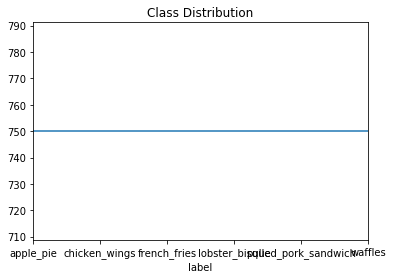

In [128]:
df_train.groupby('label').count()['path'].plot(title='Class Distribution')

In [129]:
images_per_group = 750
val_pct = .1
images_per_val = int(val_pct * images_per_group)
#Group by label and get a random sample within each group, get indices and assign validation flag
val_idx = df_train.groupby('label').apply(lambda x: x.sample(images_per_val)).index.get_level_values(1)
df_train.loc[val_idx, 'is_val'] = 1

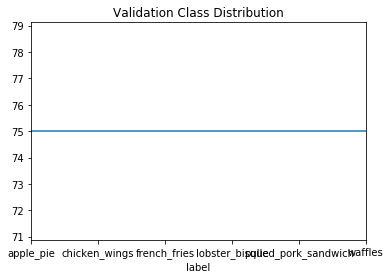

In [142]:
#The validation set preserves the original class distribution
df_train.loc[df_train.is_val == 1].groupby('label').count()['path'].plot(title='Validation Class Distribution')

## Loading <a id='data-loading'></a>
The data bunch will be instantiated from DataFrame using fast.ai's data block API. A frame specifying the path and label of all training images is passed in first. Next we define how to split out a validation set from the training set and specify what column in the DataFrame contains the image labels. Afterwards we apply image transformations and resize all images to the same size. See below for a more detailed explanation on transformations. Finally we construct the data bunch with a given batch size.

In [134]:
bs=16 #Batch size of 16
size=224 #Image size of 224x224

### Transformations <a id='data-transformations'></a>
Data augmentation is an important part of training computer vision models. Augmentation or transformation is the process by which training images are randomly modified, effectively multiplying the size of the training set without the need for additional images!

fast.ai provides a comprehensive image transformation [library](https://docs.fast.ai/vision.transform.html). Transformations are applied on the fly as images are taken off the data loader. A variety of methods are available including zooming, stretching, brightness, contrast and much more. For this data set I am flipping horizontally but not vertically (as I would not expect to see an image of food upside down); and am using fast.ai's default settings for rotation, zoom, lighting and warp.

In [135]:
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      )

In [140]:
data = (ImageList.from_df(df_train, path=path/'images', suffix='.jpg')
        .split_from_df(col='is_val')
        .label_from_df(cols='label')
        .transform(tfms, size=size)
        .databunch(bs=bs))

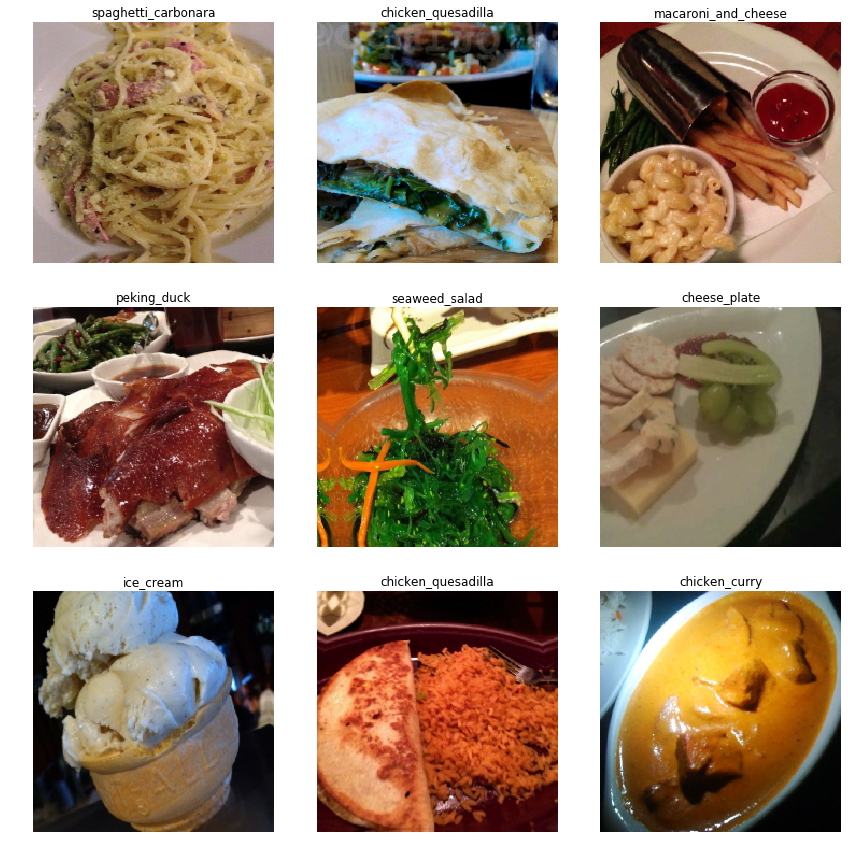

In [143]:
#Preview the data
data.show_batch(rows=3)

# Model <a id='model'></a>

## Architecture and Instantiation <a id='model-architecture-inst'></a>
With the data bunch prepared, I can instantiate the model. fast.ai provides a convenient architecture with its [Learner](https://docs.fast.ai/vision.learner.html) module. Since I will be doing multi-category image recognition I will use a convolutional neural net. Specifically, I will use a [Resnet-50](https://arxiv.org/abs/1512.03385) architecture, pre-trained on [Imagenet](http://image-net.org/challenges/LSVRC/). Pre-training is a very improtant feature of the model--it leverages weights that have already been trained on the Imagenet dataset as a starting point for the model. The fast.ai Learner uses the pre-trained weights for the bulk of the model but adds additional layers at the end so that the output fits the 101 food classes instead of Imagenet's 1000. Since I will be using weights pre-trained on Imagenet, it is important that the data is normalized by the Imagenet stats.

In [147]:
data.normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])

In [148]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

# Training <a id='training'></a>

## Learning Rate <a id='training-learning-rate'></a>
The first step to training is determining the learning rate to use. The learning rate defines the size of the step taken in Stochastic Gradient Descent. A large learning rate can mean faster convergence, but can also skip over local minima and in some cases prevent convergence at all. A small learning rate can mean a more complete coverage of the loss surface but may take a very long time to converge. In fast.ai, a range of learning rates can be specified which allows the model to use a large learning rate at the beginning and smaller learning at the end for fine tuning. Using the lr_find function, I can find the optimal range of learning rates to pass to the Learner.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


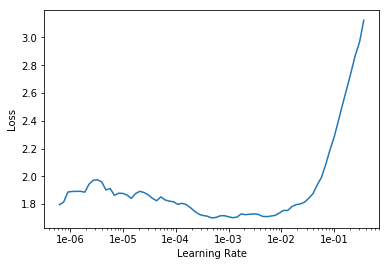

In [151]:
learn.lr_find()
learn.recorder.plot()

## Fitting <a id='training-fitting'></a>
After finding the learning rate, I can begin fitting the model. By default, fast.ai freezes the pre-trained Imagenet layers and only trains the additional layers it has added on. I start by fitting these additional layers first. After sufficient training, I unfreeze the pre-trained layers and train those as well.

In [152]:
learn.fit_one_cycle(1, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.676847,1.257964,0.679208,11:23
